<a href="https://colab.research.google.com/github/AlexeyTri/PyTorchTutorials_2025/blob/main/13_RNN_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
assert sys.version_info >= (3, 10)
import torch
import torch.nn as nn
torch.manual_seed(42)

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 8.0 MB/s eta 0:00:00


In [ ]:
import torchmetrics
import torch
from packaging.version import Version

assert Version(torch.__version__) >= Version("2.8.0")

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device

'cpu'

# Прогнозирование временного ряда

In [74]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def download_and_extract_ridership_data():
    tarball_path = Path("datasets/ridership.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/AlexeyTri/PyTorchTutorials_2025/blob/main/data/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets", filter="data")

In [ ]:
download_and_extract_ridership_data()

In [ ]:
path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [ ]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


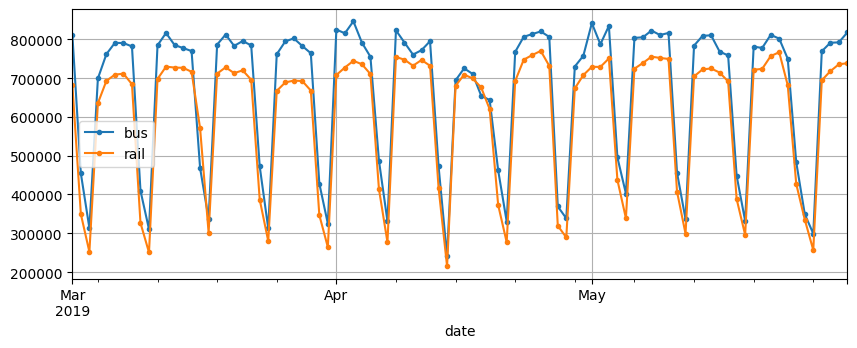

In [ ]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(10, 3.5))
plt.show()

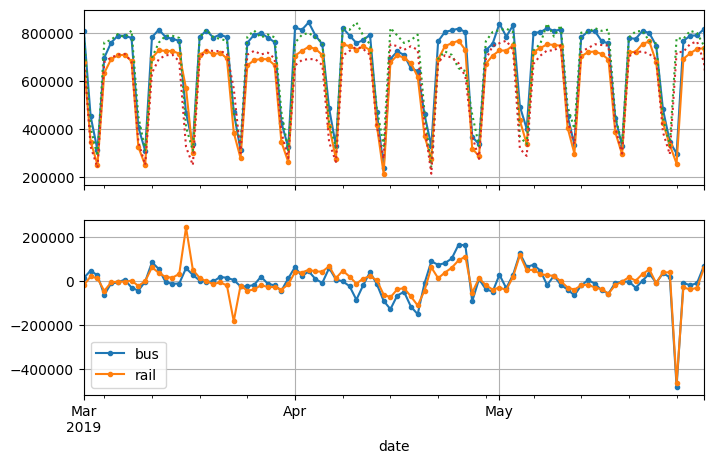

In [ ]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot

plt.show()

In [ ]:
[(df.loc["2019-05-25":"2019-05-27"]["day_type"])]

[date
 2019-05-25    A
 2019-05-26    U
 2019-05-27    U
 Name: day_type, dtype: object]

In [ ]:
# MAE
diff_7.abs().mean()

,0
bus,43915.608696
rail,42143.271739


In [ ]:
# MAPE
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

,0
bus,0.082938
rail,0.089948


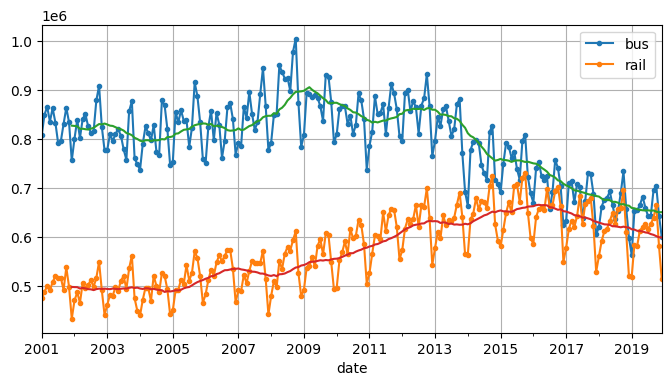

In [14]:
period = slice("2001", "2019")
df_monthly = df.select_dtypes(include="number").resample("ME").mean()
rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

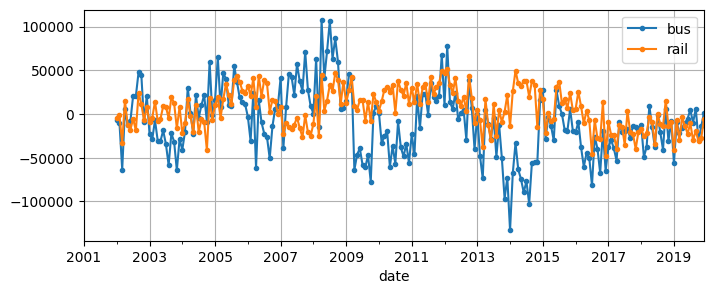

In [15]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

**ARMA**



In [16]:
!pip install statsmodels
import statsmodels

In [17]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")

model = ARIMA(rail_series,
              order=(1, 0, 0), # p=1, d=0, q=0
              seasonal_order=(0, 1, 1, 7)) # p=0, d=1, q=1, s=7

model = model.fit()

y_pred = model.forecast()
y_pred.item() - df.loc["2019-06-01"]["rail"].item()

48714.62642106105

In [18]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],
                  order=(1,0,0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()
    y_pred = model.forecast().iloc[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()
mae.item()

32040.720094289627

/tmp/ipython-input-2360366094.py:3: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")


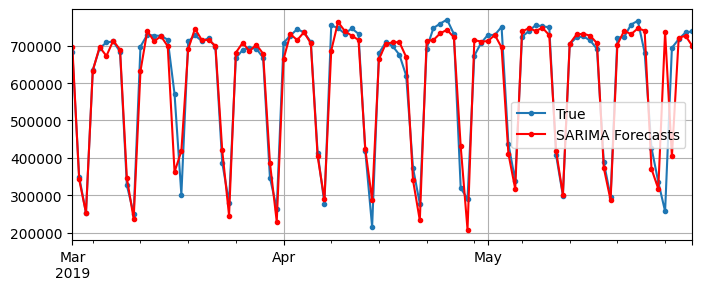

In [19]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

**Подготовка данных**

In [20]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, series, window_length):
        self.series = series
        self.window_length = window_length

    def __len__(self):
        return (len(self.series) - self.window_length)

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("dataset index out of range")
        end = idx + self.window_length
        window = self.series[idx:end]
        target = self.series[end]
        return window, target

In [21]:
my_series = torch.tensor([[0], [1], [2], [3], [4], [5], [6], [7]])
time_series = TimeSeriesDataset(my_series, 3)
for window, target in time_series:
    print(f"window: {window}, target: {target}")

window: tensor([[0],
        [1],
        [2]]), target: tensor([3])
window: tensor([[1],
        [2],
        [3]]), target: tensor([4])
window: tensor([[2],
        [3],
        [4]]), target: tensor([5])
window: tensor([[3],
        [4],
        [5]]), target: tensor([6])
window: tensor([[4],
        [5],
        [6]]), target: tensor([7])


In [22]:
from torch.utils.data import DataLoader

torch.manual_seed(0)
my_loader = DataLoader(time_series, batch_size=2, shuffle=True)
for X, y in my_loader:
    print(f"X: {X}, y: {y}")

X: tensor([[[1],
         [2],
         [3]],

        [[4],
         [5],
         [6]]]), y: tensor([[4],
        [7]])
X: tensor([[[2],
         [3],
         [4]],

        [[3],
         [4],
         [5]]]), y: tensor([[5],
        [6]])
X: tensor([[[0],
         [1],
         [2]]]), y: tensor([[3]])


In [23]:
rail_train = torch.FloatTensor(df[["rail"]]["2016-01":"2018-12"].values / 1e6)
rail_valid = torch.FloatTensor(df[["rail"]]["2019-01":"2019-05"].values / 1e6)
rail_test = torch.FloatTensor(df[["rail"]]["2019-06":].values / 1e6)

In [24]:
window_length = 56
train_set = TimeSeriesDataset(rail_train, window_length)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_set = TimeSeriesDataset(rail_valid, window_length)
valid_loader = DataLoader(valid_set, batch_size=32)
test_set = TimeSeriesDataset(rail_test, window_length)
test_loader = DataLoader(test_set, batch_size=32)

In [25]:
!pip install torchmetrics

In [26]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

In [27]:
def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs, patience=10, factor=0.1):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=patience, factor=factor)
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        scheduler.step(val_metric)
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

In [28]:
model = nn.Sequential(nn.Flatten(), nn.Linear(window_length, 1)).to(device)
loss_fn = nn.HuberLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
metric = torchmetrics.MeanAbsoluteError().to(device)

history = train(model, optimizer, loss_fn, metric, train_loader,
                valid_loader, n_epochs=50)

Epoch 1/50, train loss: 0.0689, train metric: 0.2903, valid metric: 0.1464
Epoch 2/50, train loss: 0.0125, train metric: 0.1230, valid metric: 0.1031
Epoch 3/50, train loss: 0.0082, train metric: 0.0966, valid metric: 0.0762
Epoch 4/50, train loss: 0.0066, train metric: 0.0834, valid metric: 0.0702
Epoch 5/50, train loss: 0.0062, train metric: 0.0779, valid metric: 0.0668
Epoch 6/50, train loss: 0.0058, train metric: 0.0750, valid metric: 0.0658
Epoch 7/50, train loss: 0.0055, train metric: 0.0726, valid metric: 0.0631
Epoch 8/50, train loss: 0.0054, train metric: 0.0725, valid metric: 0.0595
Epoch 9/50, train loss: 0.0051, train metric: 0.0695, valid metric: 0.0598
Epoch 10/50, train loss: 0.0051, train metric: 0.0680, valid metric: 0.0619
Epoch 11/50, train loss: 0.0050, train metric: 0.0690, valid metric: 0.0585
Epoch 12/50, train loss: 0.0049, train metric: 0.0666, valid metric: 0.0579
Epoch 13/50, train loss: 0.0047, train metric: 0.0655, valid metric: 0.0584
Epoch 14/50, train lo

In [29]:
evaluate_tm(model, valid_loader, metric).item() * 1e6

45045.53973674774

# Simple RNN

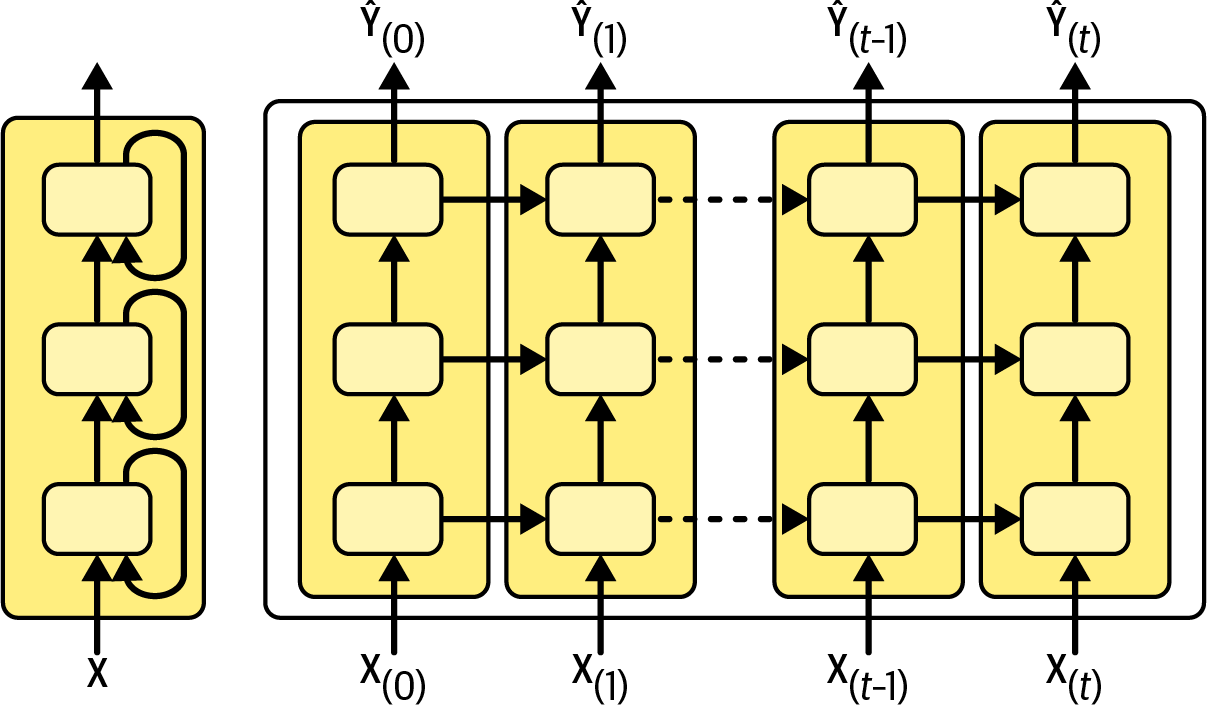



In [30]:
class SimleRnnModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.memmory_cell = nn.Sequential(nn.Linear(input_size + hidden_size, hidden_size), nn.Tanh())
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        batch_size, window_length, dimetionaly = X.shape
        X_time_first = X.transpose(0, 1)
        H = torch.zeros(batch_size, self.hidden_size, device=X.device)
        for X_t in X_time_first:
            XH = torch.cat((X_t, H), dim=1)
            H = self.memmory_cell(XH)
        return self.output(H)

In [31]:
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)
    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs[:, -1])

In [32]:
univar_model = SimleRnnModel(input_size=1, hidden_size=32, output_size=1)

In [33]:
def fit_and_evaluate(model, train_loader, valid_loader, lr, n_epochs=50, patience=20, factor=0.1):
    loss_fn = nn.HuberLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    metric = torchmetrics.MeanAbsoluteError().to(device)

    history = train(model, optimizer=optimizer, loss_fn=loss_fn, metric=metric, train_loader=train_loader, valid_loader=valid_loader, n_epochs=n_epochs, patience=patience, factor=factor)

    return min(history["valid_metrics"]) * 1e6

In [34]:
univar_model = SimpleRNNModel(input_size=1, hidden_size=32, output_size=1)
univar_model = univar_model.to(device)
fit_and_evaluate(model=univar_model, train_loader=train_loader, valid_loader=valid_loader, lr=0.05)

Epoch 1/50, train loss: 0.0426, train metric: 0.2302, valid metric: 0.1781
Epoch 2/50, train loss: 0.0154, train metric: 0.1470, valid metric: 0.1194
Epoch 3/50, train loss: 0.0132, train metric: 0.1438, valid metric: 0.1245
Epoch 4/50, train loss: 0.0122, train metric: 0.1351, valid metric: 0.1146
Epoch 5/50, train loss: 0.0114, train metric: 0.1282, valid metric: 0.1181
Epoch 6/50, train loss: 0.0106, train metric: 0.1231, valid metric: 0.1117
Epoch 7/50, train loss: 0.0098, train metric: 0.1166, valid metric: 0.1038
Epoch 8/50, train loss: 0.0087, train metric: 0.1060, valid metric: 0.1118
Epoch 9/50, train loss: 0.0075, train metric: 0.0965, valid metric: 0.0966
Epoch 10/50, train loss: 0.0066, train metric: 0.0880, valid metric: 0.0865
Epoch 11/50, train loss: 0.0057, train metric: 0.0809, valid metric: 0.0706
Epoch 12/50, train loss: 0.0054, train metric: 0.0766, valid metric: 0.0664
Epoch 13/50, train loss: 0.0051, train metric: 0.0746, valid metric: 0.0686
Epoch 14/50, train lo

30768.657103180885

In [35]:
class DeepRnnModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs[:, -1])

In [36]:
deep_model = DeepRnnModel(input_size=1, hidden_size=32, output_size=1, num_layers=3).to(device)
fit_and_evaluate(model=deep_model, train_loader=train_loader, valid_loader=valid_loader, lr=0.07, n_epochs=50)

Epoch 1/50, train loss: 0.0437, train metric: 0.2295, valid metric: 0.1578
Epoch 2/50, train loss: 0.0167, train metric: 0.1589, valid metric: 0.1285
Epoch 3/50, train loss: 0.0155, train metric: 0.1553, valid metric: 0.1229
Epoch 4/50, train loss: 0.0134, train metric: 0.1414, valid metric: 0.0973
Epoch 5/50, train loss: 0.0095, train metric: 0.1073, valid metric: 0.1159
Epoch 6/50, train loss: 0.0083, train metric: 0.0995, valid metric: 0.0878
Epoch 7/50, train loss: 0.0074, train metric: 0.0937, valid metric: 0.0812
Epoch 8/50, train loss: 0.0067, train metric: 0.0871, valid metric: 0.0797
Epoch 9/50, train loss: 0.0061, train metric: 0.0813, valid metric: 0.0731
Epoch 10/50, train loss: 0.0051, train metric: 0.0732, valid metric: 0.0629
Epoch 11/50, train loss: 0.0047, train metric: 0.0679, valid metric: 0.0543
Epoch 12/50, train loss: 0.0045, train metric: 0.0662, valid metric: 0.0513
Epoch 13/50, train loss: 0.0045, train metric: 0.0649, valid metric: 0.0541
Epoch 14/50, train lo

31595.78889608383

**Multivariate time series**

In [37]:
df_mulvar = df[["rail", "bus"]] / 1e6
df_mulvar["next_day_type"] = df["day_type"].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar, dtype=float)

In [38]:
mulvar_train = torch.FloatTensor(df_mulvar["2016-01":"2018-12"].values)
mulvar_test = torch.FloatTensor(df_mulvar["2019-06":].values)
mulvar_valid = torch.FloatTensor(df_mulvar["2019-01":"2019-05"].values)

In [39]:
class MultiTimeSeries(TimeSeriesDataset):
    def __getitem__(self, idx):
        window, target = super().__getitem__(idx)
        return window, target[:2]

In [40]:
window_length = 56
multivar_train_set = MultiTimeSeries(mulvar_train, window_length)
multivar_train_loader = DataLoader(multivar_train_set, batch_size=32, shuffle=True)
multivar_test_set = MultiTimeSeries(mulvar_test, window_length)
multivar_test_loader = DataLoader(mulvar_test, batch_size=32)
multivar_val_set = MultiTimeSeries(mulvar_valid, window_length)
multivar_valid_loader = DataLoader(multivar_val_set, batch_size=32)

In [41]:
mulvar_model = SimpleRNNModel(input_size=5, hidden_size=32, output_size=2)
mulvar_model = mulvar_model.to(device)

In [42]:
fit_and_evaluate(model=mulvar_model, train_loader=multivar_train_loader, valid_loader=multivar_valid_loader, lr=0.03, n_epochs=50)

Epoch 1/50, train loss: 0.0589, train metric: 0.2398, valid metric: 0.0915
Epoch 2/50, train loss: 0.0032, train metric: 0.0595, valid metric: 0.0419
Epoch 3/50, train loss: 0.0021, train metric: 0.0447, valid metric: 0.0340
Epoch 4/50, train loss: 0.0020, train metric: 0.0432, valid metric: 0.0405
Epoch 5/50, train loss: 0.0019, train metric: 0.0420, valid metric: 0.0354
Epoch 6/50, train loss: 0.0018, train metric: 0.0411, valid metric: 0.0354
Epoch 7/50, train loss: 0.0017, train metric: 0.0408, valid metric: 0.0343
Epoch 8/50, train loss: 0.0017, train metric: 0.0406, valid metric: 0.0397
Epoch 9/50, train loss: 0.0017, train metric: 0.0399, valid metric: 0.0329
Epoch 10/50, train loss: 0.0017, train metric: 0.0394, valid metric: 0.0296
Epoch 11/50, train loss: 0.0016, train metric: 0.0400, valid metric: 0.0322
Epoch 12/50, train loss: 0.0016, train metric: 0.0395, valid metric: 0.0404
Epoch 13/50, train loss: 0.0016, train metric: 0.0395, valid metric: 0.0330
Epoch 14/50, train lo

25926.249101758003

In [43]:
mulvar_model.eval()
Y_pred_valid = [mulvar_model(X.to(device)) for X, _ in multivar_valid_loader]
Y_pred_valid = torch.cat(Y_pred_valid, dim=0)
Y_valid = torch.cat([Y.to(device) for _, Y in multivar_valid_loader], dim=0)
for idx, name in enumerate(["bus", "rail"]):
    mae = (Y_pred_valid[:, idx] - Y_valid[:, idx]).abs().mean()
    print(name, int(mae * 1e6))

bus 35342
rail 27883


In [44]:
class SimpleRnnModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs[:, -1])

class MultaskTimeSeriesDataset(TimeSeriesDataset):
    def __getitem__(self, idx):
        window, target = super().__getitem__(idx)
        return window, target[:2]

window_length = 56
multask_train_set = MultaskTimeSeriesDataset(mulvar_train, window_length)
multask_train_loader = DataLoader(multask_train_set, batch_size=32, shuffle=True)
multask_valid_set = MultaskTimeSeriesDataset(mulvar_valid, window_length)
multask_valid_loader = DataLoader(multask_valid_set, batch_size=32)
multask_test_set = MultaskTimeSeriesDataset(mulvar_test, window_length)
multask_test_loader = DataLoader(multask_test_set, batch_size=32)

torch.manual_seed(42)
multask_model = SimpleRnnModel(input_size=5, hidden_size=32, output_size=2)
multask_model = multask_model.to(device)
fit_and_evaluate(multask_model, multask_train_loader, multask_valid_loader, lr=0.03, n_epochs=50)

Epoch 1/50, train loss: 0.0514, train metric: 0.2416, valid metric: 0.1217
Epoch 2/50, train loss: 0.0042, train metric: 0.0697, valid metric: 0.0371
Epoch 3/50, train loss: 0.0023, train metric: 0.0485, valid metric: 0.0437
Epoch 4/50, train loss: 0.0022, train metric: 0.0456, valid metric: 0.0308
Epoch 5/50, train loss: 0.0021, train metric: 0.0451, valid metric: 0.0351
Epoch 6/50, train loss: 0.0021, train metric: 0.0452, valid metric: 0.0363
Epoch 7/50, train loss: 0.0020, train metric: 0.0438, valid metric: 0.0373
Epoch 8/50, train loss: 0.0020, train metric: 0.0437, valid metric: 0.0352
Epoch 9/50, train loss: 0.0019, train metric: 0.0423, valid metric: 0.0325
Epoch 10/50, train loss: 0.0019, train metric: 0.0421, valid metric: 0.0362
Epoch 11/50, train loss: 0.0019, train metric: 0.0418, valid metric: 0.0305
Epoch 12/50, train loss: 0.0018, train metric: 0.0418, valid metric: 0.0359
Epoch 13/50, train loss: 0.0018, train metric: 0.0409, valid metric: 0.0307
Epoch 14/50, train lo

24533.256888389587

In [45]:
multask_model.eval()
Y_pred_s = [mulvar_model(X.to(device)) for X, _ in multask_valid_loader]
Y_pred_s = torch.cat(Y_pred_s, dim=0)
Y_valid = torch.cat([Y.to(device) for _, Y in multask_valid_loader], dim=0)
for idx, name in enumerate(["bus", "rail"]):
    mae = (Y_pred_s[:, idx] - Y_valid[:, idx]).abs().mean()
    print(name, int(mae*1e6))

bus 35342
rail 27883


**Forecasting Several Steps Ahead**

In [46]:
univar_model.eval()
n_steps = 14
with torch.no_grad():
    X = rail_valid[:window_length].unsqueeze(dim=0).to(device)
    for _ in range(n_steps):
        Y_pred = univar_model(X)
        X = torch.cat([X, Y_pred.unsqueeze(dim=0)], dim=1)
    Y_pred = X[0, -n_steps:, 0]

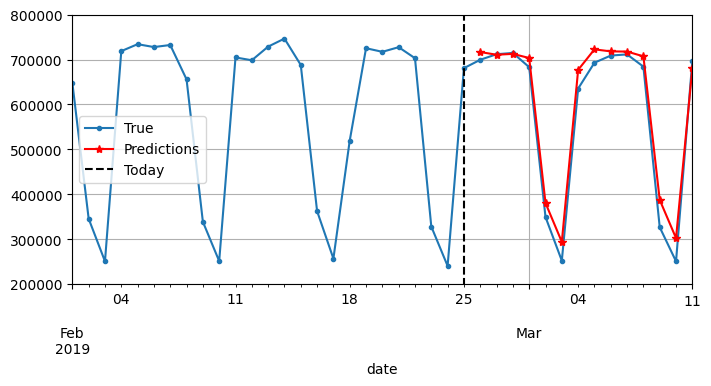

In [47]:
Y_pred_s = pd.Series(Y_pred.cpu() * 1e6, index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
df["2019-02-01":"2019-03-11"]["rail"].plot(label="True", marker=".", ax=ax)
Y_pred_s.plot(label="Predictions", grid=True, marker="*", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

In [48]:
class ForecastAheadDataset(TimeSeriesDataset):
    def __len__(self):
        return len(self.series) - self.window_length - 14 + 1

    def __getitem__(self, idx):
        end = idx + self.window_length
        window = self.series[idx:end]
        target = self.series[end : end + 14, 0]
        return window, target

In [49]:
window_length = 56
ahead_train_set = ForecastAheadDataset(mulvar_train, window_length)
ahead_train_loader = DataLoader(ahead_train_set, batch_size=32, shuffle=True)
ahead_valid_set = ForecastAheadDataset(mulvar_valid, window_length)
ahead_valid_loader = DataLoader(ahead_valid_set, batch_size=32)
ahead_test_set = ForecastAheadDataset(mulvar_test, window_length)
ahead_test_loader = DataLoader(ahead_test_set, batch_size=32)

In [50]:
ahead_model = SimleRnnModel(input_size=5, hidden_size=32, output_size=14)
ahead_model = ahead_model.to(device)
fit_and_evaluate(ahead_model, ahead_train_loader, ahead_valid_loader, lr=0.05, n_epochs=50)

Epoch 1/50, train loss: 0.0666, train metric: 0.2881, valid metric: 0.1589
Epoch 2/50, train loss: 0.0151, train metric: 0.1485, valid metric: 0.1249
Epoch 3/50, train loss: 0.0129, train metric: 0.1350, valid metric: 0.1142
Epoch 4/50, train loss: 0.0116, train metric: 0.1254, valid metric: 0.1074
Epoch 5/50, train loss: 0.0106, train metric: 0.1156, valid metric: 0.0995
Epoch 6/50, train loss: 0.0091, train metric: 0.1062, valid metric: 0.0915
Epoch 7/50, train loss: 0.0081, train metric: 0.0978, valid metric: 0.0862
Epoch 8/50, train loss: 0.0073, train metric: 0.0917, valid metric: 0.0820
Epoch 9/50, train loss: 0.0069, train metric: 0.0875, valid metric: 0.0782
Epoch 10/50, train loss: 0.0064, train metric: 0.0841, valid metric: 0.0749
Epoch 11/50, train loss: 0.0061, train metric: 0.0807, valid metric: 0.0729
Epoch 12/50, train loss: 0.0059, train metric: 0.0779, valid metric: 0.0701
Epoch 13/50, train loss: 0.0056, train metric: 0.0754, valid metric: 0.0661
Epoch 14/50, train lo

38150.232285261154

In [51]:
ahead_model.eval()
with torch.no_grad():
    window = mulvar_valid[:window_length]  # shape [56, 5]
    X = window.unsqueeze(dim=0)            # shape [1, 56, 5]
    Y_pred = ahead_model(X.to(device))

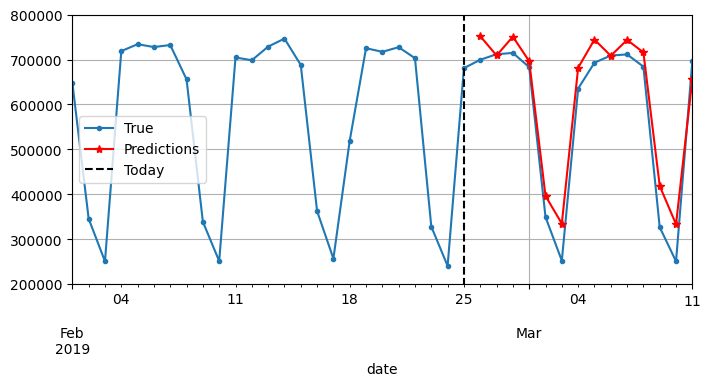

In [52]:
Y_pred_s = pd.Series(Y_pred.permute(1,0)[:,0].cpu() * 1e6, index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
df["2019-02-01":"2019-03-11"]["rail"].plot(label="True", marker=".", ax=ax)
Y_pred_s.plot(label="Predictions", grid=True, marker="*", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

**Forecasting Using a Sequence-to-Sequence Model**

In [53]:
class Seq2SeqDataset(ForecastAheadDataset):
    def __getitem__(self, idx):
        end = idx + self.window_length
        window = self.series[idx:end]
        target_period = self.series[idx + 1 : end + 14, 0]
        target = target_period.unfold(dimension=0, size=14, step=1)
        return window, target

In [54]:
window_length = 56
seq_train_set = Seq2SeqDataset(mulvar_train, window_length)
seq_train_loader = DataLoader(seq_train_set, batch_size=32, shuffle=True)
seq_valid_set = Seq2SeqDataset(mulvar_valid, window_length)
seq_valid_loader = DataLoader(seq_valid_set, batch_size=32)
seq_test_set = Seq2SeqDataset(mulvar_test, window_length)
seq_test_loader = DataLoader(seq_test_set, batch_size=32)

In [55]:
class Seq2SeqRNNModel(SimpleRnnModel):
    def forward(self, X):
        outputs, last_state = self.rnn(X)
        return self.output(outputs)

In [56]:
seq_model = Seq2SeqRNNModel(input_size=5, hidden_size=32, output_size=14)
seq_model = seq_model.to(device)
fit_and_evaluate(model=seq_model, train_loader=seq_train_loader, valid_loader=seq_valid_loader, lr=1.0, n_epochs=65, patience=5, factor=0.5)

Epoch 1/65, train loss: 0.0308, train metric: 0.1852, valid metric: 0.1139
Epoch 2/65, train loss: 0.0055, train metric: 0.0725, valid metric: 0.0634
Epoch 3/65, train loss: 0.0042, train metric: 0.0591, valid metric: 0.0728
Epoch 4/65, train loss: 0.0039, train metric: 0.0560, valid metric: 0.0626
Epoch 5/65, train loss: 0.0037, train metric: 0.0537, valid metric: 0.0488
Epoch 6/65, train loss: 0.0037, train metric: 0.0533, valid metric: 0.0477
Epoch 7/65, train loss: 0.0037, train metric: 0.0533, valid metric: 0.0470
Epoch 8/65, train loss: 0.0036, train metric: 0.0526, valid metric: 0.0614
Epoch 9/65, train loss: 0.0035, train metric: 0.0509, valid metric: 0.0573
Epoch 10/65, train loss: 0.0034, train metric: 0.0497, valid metric: 0.0655
Epoch 11/65, train loss: 0.0034, train metric: 0.0512, valid metric: 0.0496
Epoch 12/65, train loss: 0.0034, train metric: 0.0491, valid metric: 0.0483
Epoch 13/65, train loss: 0.0033, train metric: 0.0493, valid metric: 0.0488
Epoch 14/65, train lo

47014.154493808746

In [57]:
seq_model.eval()
with torch.no_grad():
    some_window = mulvar_valid[:window_length]
    X = some_window.unsqueeze(dim=0)
    Y_preds = seq_model(X.to(device))
    Y_pred = Y_preds[:, -1]

In [58]:
with torch.no_grad():
    X =mulvar_valid.unsqueeze(dim=0).to(device)
    Y_preds_valid = seq_model(X).cpu()

for ahead in range(1, 14 + 1):
    y_preds = Y_preds_valid[0, window_length : -ahead, ahead - 1]
    y_true = rail_valid[window_length + ahead:, 0]
    mae = (y_preds - y_true).abs().mean() * 1e6
    print(f"MAE for +{ahead}:\t{mae:,.0f}")

MAE for +1:	24,058
MAE for +2:	34,005
MAE for +3:	37,123
MAE for +4:	37,709
MAE for +5:	38,727
MAE for +6:	38,820
MAE for +7:	38,417
MAE for +8:	38,324
MAE for +9:	39,754
MAE for +10:	37,590
MAE for +11:	37,539
MAE for +12:	37,159
MAE for +13:	36,621
MAE for +14:	33,697


In [59]:
torch.manual_seed(42)
with torch.no_grad():
    X = torch.randn(10, 56, 32)
    conv1d = nn.Conv1d(32, 14, kernel_size=1)
    linear = nn.Linear(32, 14)
    linear.weight.data = conv1d.weight.squeeze(dim=2)
    linear.bias.data = conv1d.bias
    result1 = conv1d(X.permute(0, 2, 1)).permute(0, 2, 1)
    result2 = linear(X)

torch.allclose(result1, result2, atol=1e-7)

True

**Deep RNNs with Layer Norm**

In [60]:
class SimpleRnnWithLN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.memmory_cell = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.Tanh()
        )
        self.output = nn.Linear(hidden_size, output_size)
    def forward(self, X):
        batch_size, window_length, dimensionality = X.shape
        X_time_first = X.transpose(0, 1)
        H = torch.zeros(batch_size, self.hidden_size, device=X.device)
        for X_t in X_time_first:
            XH = torch.cat((X_t, H), dim=1)
            H = self.memmory_cell(XH)
        return self.output(H)

In [61]:
rnn_with_layer_norm = SimpleRnnWithLN(input_size=5, hidden_size=32, output_size=14)
rnn_with_layer_norm = rnn_with_layer_norm.to(device)
fit_and_evaluate(rnn_with_layer_norm, ahead_train_loader, ahead_valid_loader, lr=0.05, n_epochs=2)

Epoch 1/2, train loss: 0.0948, train metric: 0.3336, valid metric: 0.1777
Epoch 2/2, train loss: 0.0174, train metric: 0.1528, valid metric: 0.1288


128820.35970687866

**LSTMs**

In [62]:
class LstmModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.memmory_cell = nn.LSTMCell(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        batch_size, window_length, dimensionality = X.shape
        X_time_first = X.transpose(0, 1)
        H = torch.zeros(batch_size, self.hidden_size, device=X.device)
        C = torch.zeros(batch_size, self.hidden_size, device=X.device)
        for X_t in X_time_first:
            H, C = self.memmory_cell(X_t, (H, C))
        return self.output(H)

In [63]:
torch.manual_seed(42)
lstm_model = LstmModel(input_size=5, hidden_size=32, output_size=14)
lstm_model = lstm_model.to(device)
fit_and_evaluate(lstm_model, ahead_train_loader, ahead_valid_loader, lr=0.05, n_epochs=2)

Epoch 1/2, train loss: 0.1036, train metric: 0.3962, valid metric: 0.1534
Epoch 2/2, train loss: 0.0175, train metric: 0.1480, valid metric: 0.1414


141420.9008216858

**GRUs**

In [64]:
class GruModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.memory_cell = nn.GRUCell(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        batch_size, window_length, dimensionality = X.shape
        X_time_first = X.transpose(0, 1)
        H = torch.zeros(batch_size, self.hidden_size, device=X.device)
        for X_t in X_time_first:
            H = self.memory_cell(X_t, H)
        return self.output(H)

In [65]:
torch.manual_seed(42)
gru_model = GruModel(input_size=5, hidden_size=32, output_size=14)
gru_model = gru_model.to(device)
fit_and_evaluate(gru_model, ahead_train_loader, ahead_valid_loader,
                 lr=0.05, n_epochs=2)

Epoch 1/2, train loss: 0.0785, train metric: 0.3166, valid metric: 0.1443
Epoch 2/2, train loss: 0.0170, train metric: 0.1571, valid metric: 0.1359


135890.6477689743

**Using One-Dimensional Convolutional Layers to Process Sequences**

In [66]:
class DownsamplingModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.conv = nn.Conv1d(input_size, hidden_size, kernel_size=4, stride=2)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)


    def forward(self, X):
        Z = X.permute(0, 2, 1)
        Z = self.conv(Z)
        Z = Z.permute(0, 2, 1)
        Z = torch.relu(Z)
        Z, _states = self.gru(Z)
        return self.linear(Z)

In [67]:
torch.manual_seed(42)
dseq_model = DownsamplingModel(input_size=1, hidden_size=32, output_size=14)
dseq_model = dseq_model.to(device)

In [68]:
class DownsampledDataset(Seq2SeqDataset):
    def __getitem__(self, idx):
        window, target = super().__getitem__(idx)
        return window, target[3::2]  # crop the first 3 targets and downsample

window_length = 112
dseq_train_set = DownsampledDataset(rail_train, window_length)
dseq_train_loader = DataLoader(dseq_train_set, batch_size=32, shuffle=True)
dseq_valid_set = DownsampledDataset(rail_valid, window_length)
dseq_valid_loader = DataLoader(dseq_valid_set, batch_size=32)
dseq_test_set = DownsampledDataset(rail_test, window_length)
dseq_test_loader = DataLoader(dseq_test_set, batch_size=32)

In [69]:
torch.manual_seed(42)
dseq_model = DownsamplingModel(input_size=1, hidden_size=32, output_size=14)
dseq_model = dseq_model.to(device)
fit_and_evaluate(dseq_model, dseq_train_loader, dseq_valid_loader,
                 lr=0.2, n_epochs=2)

Epoch 1/2, train loss: 0.0510, train metric: 0.2497, valid metric: 0.1676
Epoch 2/2, train loss: 0.0169, train metric: 0.1581, valid metric: 0.1486


148577.85403728485

**WaveNet**

In [70]:
import torch.nn.functional as F

class CausalConv1d(nn.Conv1d):
    def forward(self, X):
        padding = (self.kernel_size[0] - 1) * self.dilation[0]
        X = F.pad(X, (padding, 0))
        return super().forward(X)

In [71]:
class WavenetModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        layers = []
        for dilation in (1, 2, 4, 8) * 2:
            conv = CausalConv1d(input_size, hidden_size, kernel_size=2,
                                dilation=dilation)
            layers += [conv, nn.ReLU()]
            input_size = hidden_size
        self.convs = nn.Sequential(*layers)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        Z = X.permute(0, 2, 1)
        Z = self.convs(Z)
        Z = Z.permute(0, 2, 1)
        return self.output(Z)

torch.manual_seed(42)
wavenet_model = WavenetModel(input_size=5, hidden_size=32, output_size=14)
wavenet_model = wavenet_model.to(device)

In [72]:
fit_and_evaluate(wavenet_model, seq_train_loader, seq_valid_loader,
                 lr=0.1, n_epochs=150)

Epoch 1/150, train loss: 0.0810, train metric: 0.3227, valid metric: 0.1557
Epoch 2/150, train loss: 0.0171, train metric: 0.1602, valid metric: 0.1476
Epoch 3/150, train loss: 0.0163, train metric: 0.1564, valid metric: 0.1473
Epoch 4/150, train loss: 0.0161, train metric: 0.1586, valid metric: 0.1458
Epoch 5/150, train loss: 0.0161, train metric: 0.1577, valid metric: 0.1469
Epoch 6/150, train loss: 0.0161, train metric: 0.1577, valid metric: 0.1467
Epoch 7/150, train loss: 0.0162, train metric: 0.1578, valid metric: 0.1467
Epoch 8/150, train loss: 0.0162, train metric: 0.1584, valid metric: 0.1462
Epoch 9/150, train loss: 0.0161, train metric: 0.1578, valid metric: 0.1470
Epoch 10/150, train loss: 0.0161, train metric: 0.1576, valid metric: 0.1472
Epoch 11/150, train loss: 0.0162, train metric: 0.1585, valid metric: 0.1460
Epoch 12/150, train loss: 0.0162, train metric: 0.1572, valid metric: 0.1474
Epoch 13/150, train loss: 0.0161, train metric: 0.1582, valid metric: 0.1461
Epoch 14

145769.29807662964